# Stroke Prediction – Imputation, Modeling & X

In [2]:
!pip install imblearn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


In [3]:

df = pd.read_csv("/Users/martinsamuel/Documents/New Docs/DSI/project/healthcare-dataset-stroke-data.csv")
df = df.drop(columns=["id"])
df = df[df["gender"] != "Other"]
df.reset_index(drop=True, inplace=True)

df_original = df[df["bmi"].notna()].copy()
df_mean = df.copy()
df_median = df.copy()
df_reg = df.copy()


In [4]:

# Media
df_mean["bmi"].fillna(df_mean["bmi"].mean(), inplace=True)

# Mediana
df_median["bmi"].fillna(df_median["bmi"].median(), inplace=True)

# Regresión
known = df_reg[df_reg["bmi"].notna()]
unknown = df_reg[df_reg["bmi"].isna()]
X_train_reg = known[["age", "avg_glucose_level"]]
y_train_reg = known["bmi"]
X_test_reg = unknown[["age", "avg_glucose_level"]]

model_reg = make_pipeline(PolynomialFeatures(2), LinearRegression())
model_reg.fit(X_train_reg, y_train_reg)
preds = model_reg.predict(X_test_reg)
df_reg.loc[df_reg["bmi"].isna(), "bmi"] = preds


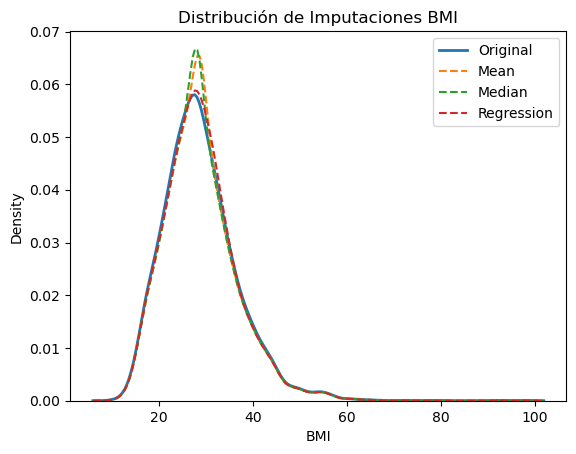

In [5]:

sns.kdeplot(df_original["bmi"], label="Original", lw=2)
sns.kdeplot(df_mean["bmi"], label="Mean", linestyle="--")
sns.kdeplot(df_median["bmi"], label="Median", linestyle="--")
sns.kdeplot(df_reg["bmi"], label="Regression", linestyle="--")
plt.title("Distribución de Imputaciones BMI")
plt.xlabel("BMI")
plt.legend()
plt.show()


In [6]:

def evaluate_mse(df, method_func, label):
    df_copy = df.copy()
    known = df_copy[df_copy["bmi"].notna()].copy()
    mask = known.sample(frac=0.1, random_state=42)
    true = mask["bmi"]
    df_copy.loc[mask.index, "bmi"] = np.nan
    df_copy = method_func(df_copy)
    pred = df_copy.loc[mask.index, "bmi"]
    mse = mean_squared_error(true, pred)
    print(f"{label} MSE:", round(mse, 4))

def impute_mean(df): df["bmi"].fillna(df["bmi"].mean(), inplace=True); return df
def impute_median(df): df["bmi"].fillna(df["bmi"].median(), inplace=True); return df
def impute_reg(df):
    known = df[df["bmi"].notna()]
    unknown = df[df["bmi"].isna()]
    X_train = known[["age", "avg_glucose_level"]]
    y_train = known["bmi"]
    X_test = unknown[["age", "avg_glucose_level"]]
    model = make_pipeline(PolynomialFeatures(2), LinearRegression())
    model.fit(X_train, y_train)
    df.loc[unknown.index, "bmi"] = model.predict(X_test)
    return df

evaluate_mse(df.copy(), impute_mean, "Mean")
evaluate_mse(df.copy(), impute_median, "Median")
evaluate_mse(df.copy(), impute_reg, "Regression")


Mean MSE: 67.3356
Median MSE: 68.4395
Regression MSE: 50.1751


In [7]:

def prepare_model_data(df):
    df_model = df.dropna()
    df_model = pd.get_dummies(df_model, drop_first=True)
    X = df_model.drop("stroke", axis=1)
    y = df_model["stroke"]
    weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
    class_w = dict(zip(np.unique(y), weights))
    return X, y, class_w


In [8]:

def apply_smote(X, y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res


mean + Random Forest → AUC: 0.7676, F1: 0.2167


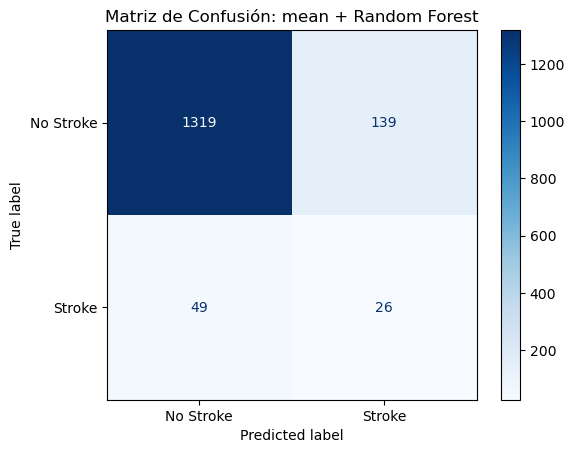

mean + Gradient Boosting → AUC: 0.8004, F1: 0.2083


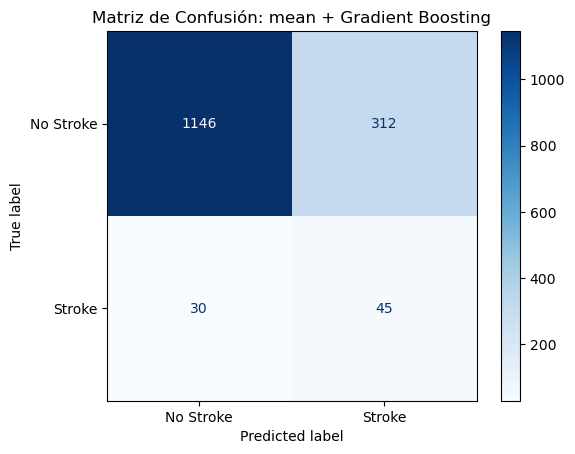

mean + Logistic Regression → AUC: 0.8159, F1: 0.1397


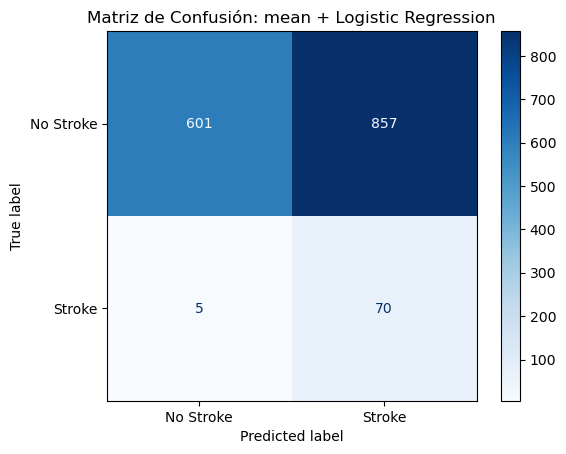

median + Random Forest → AUC: 0.7792, F1: 0.2437


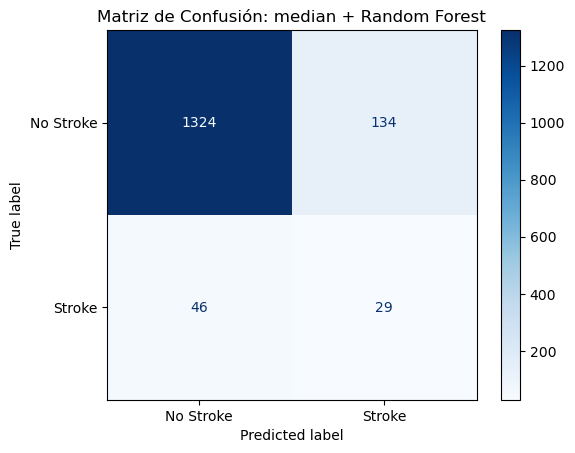

median + Gradient Boosting → AUC: 0.7989, F1: 0.2088


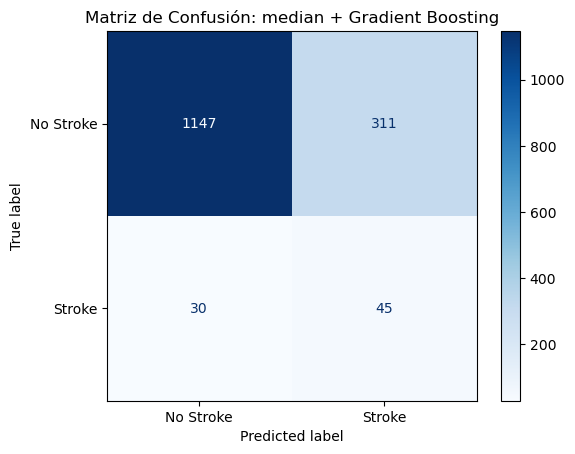

median + Logistic Regression → AUC: 0.8154, F1: 0.1389


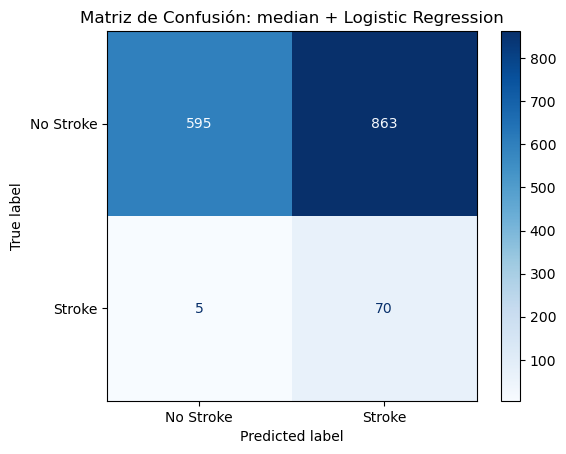

regression + Random Forest → AUC: 0.7844, F1: 0.2439


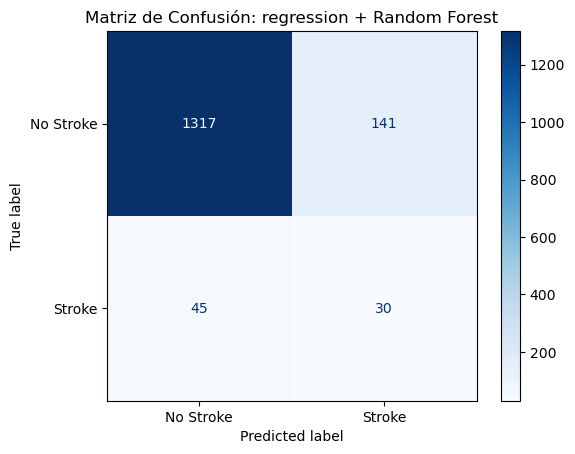

regression + Gradient Boosting → AUC: 0.8015, F1: 0.2072


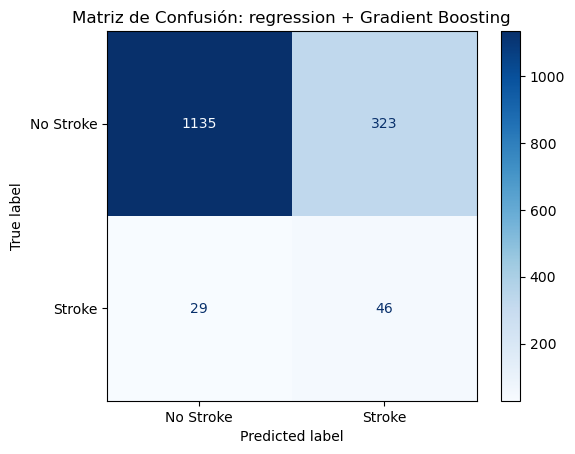

regression + Logistic Regression → AUC: 0.8176, F1: 0.1396


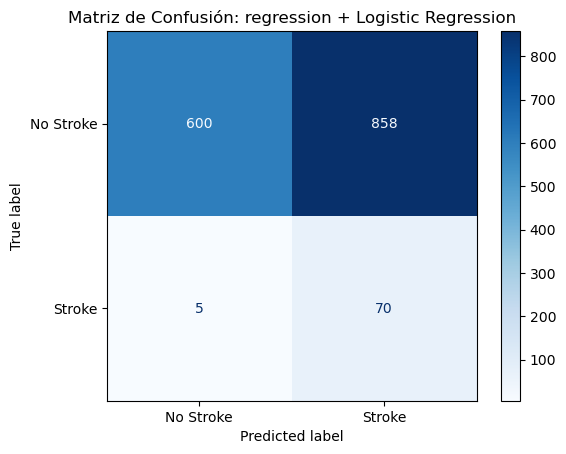

In [9]:

results_all = []

def run_models_with_visuals(df, label):
    X, y, class_w = prepare_model_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    X_train, y_train = apply_smote(X_train, y_train)

    models = {
        "Random Forest": RandomForestClassifier(random_state=42, class_weight=class_w),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight=class_w)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        threshold = 0.3
        y_pred = (y_proba >= threshold).astype(int)

        auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        results_all.append({"Imputation": label, "Model": name, "AUC": auc, "F1": f1})

        print(f"{label} + {name} → AUC: {auc:.4f}, F1: {f1:.4f}")

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])
        disp.plot(cmap="Blues")
        plt.title(f"Matriz de Confusión: {label} + {name}")
        plt.show()

run_models_with_visuals(df_mean.copy(), "mean")
run_models_with_visuals(df_median.copy(), "median")
run_models_with_visuals(df_reg.copy(), "regression")


Logistic Regression with any imputation detects better the real strokes (70/75)
Even with a lot of FP (857-863) it can be acceptable if we prioritaze not passing a real stroke as false

mean + Random Forest → AUC: 0.7676, F1: 0.2167
mean + Gradient Boosting → AUC: 0.8004, F1: 0.2083
mean + Logistic Regression → AUC: 0.8159, F1: 0.1397

median + Random Forest → AUC: 0.7792, F1: 0.2437
median + Gradient Boosting → AUC: 0.7989, F1: 0.2088
median + Logistic Regression → AUC: 0.8154, F1: 0.1389

regression + Random Forest → AUC: 0.7844, F1: 0.2439
regression + Gradient Boosting → AUC: 0.8015, F1: 0.2072
regression + Logistic Regression → AUC: 0.8176, F1: 0.1396

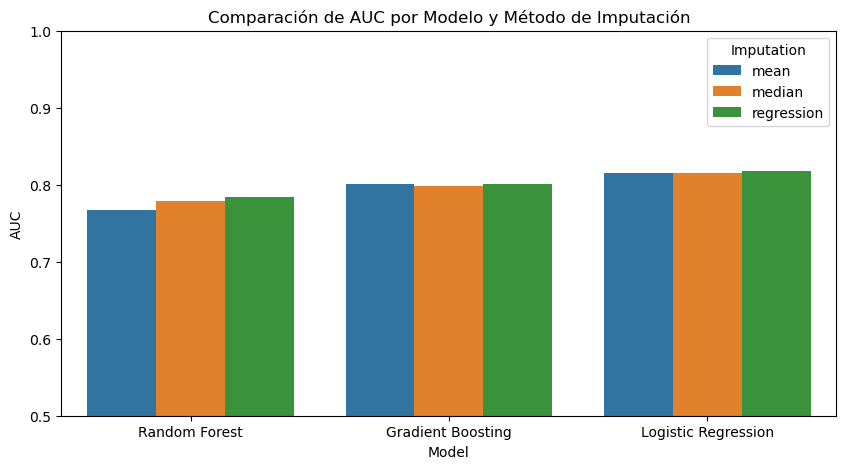

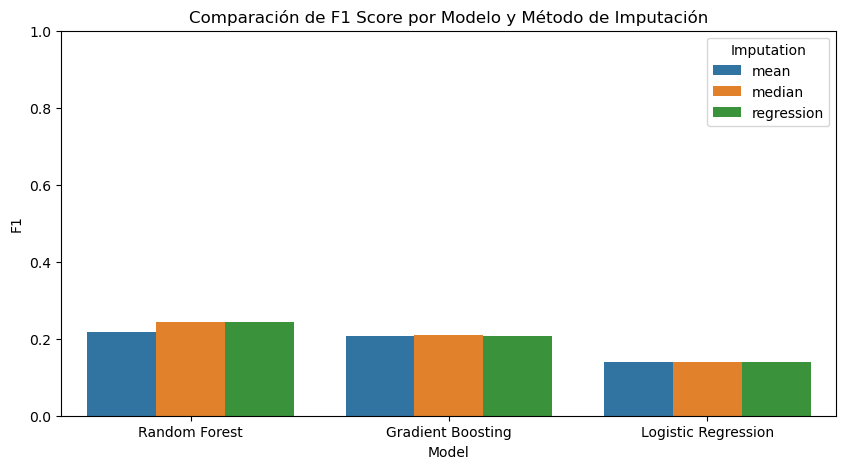

In [10]:

results_df = pd.DataFrame(results_all)

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="AUC", hue="Imputation")
plt.title("Comparación de AUC por Modelo y Método de Imputación")
plt.ylim(0.5, 1)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="F1", hue="Imputation")
plt.title("Comparación de F1 Score por Modelo y Método de Imputación")
plt.ylim(0, 1)
plt.show()


In [ ]:

# GridSearchCV para Logistic Regression
X, y, class_w = prepare_model_data(df_mean)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train, y_train = apply_smote(X_train, y